# Text Classification Again

Jimmy Harvin

In [16]:
import pandas as pd
import seaborn as sb
import imblearn as il
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import sparse
from tensorflow.keras import layers, models
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

nltk.download('stopwords')

df = pd.read_csv('./cleaned_reviews.csv', header=0, encoding='latin-1')
print('rows and columns:', df.shape)
print(df.head())

rows and columns: (17340, 4)
  sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   

   cleaned_review_length  review_score  
0                     19           5.0  
1                     88           1.0  
2                      9           2.0  
3                     12           1.0  
4                     21           1.0  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The chosen data set contains thousands of product reviews on Amazon. The fields of note are score, sentiments, and the cleaned review text; score is mapped to sentiments to create 3 categories (1-2 are negative, 3 is neutral, and 4-5 are positive) for classification. As seen in the graph below, there are far more positive and neutral reviews than negative ones, so class imbalance must be accounted for when training each model. Models should be able to predict sentiment based on the content of the cleaned reviews.

## Resampling

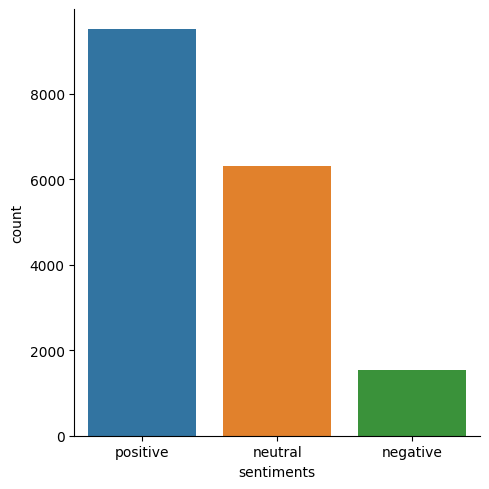

In [17]:
sb.catplot(x = "sentiments", kind = 'count', data = df)

In [18]:
df.sentiments = df['sentiments'].astype('category')
df.sentiments = df.sentiments.cat.codes
print(df.sentiments)

0        2
1        1
2        1
3        1
4        1
        ..
17335    2
17336    2
17337    2
17338    2
17339    1
Name: sentiments, Length: 17340, dtype: int8


(16586, 1)
(4335, 1)


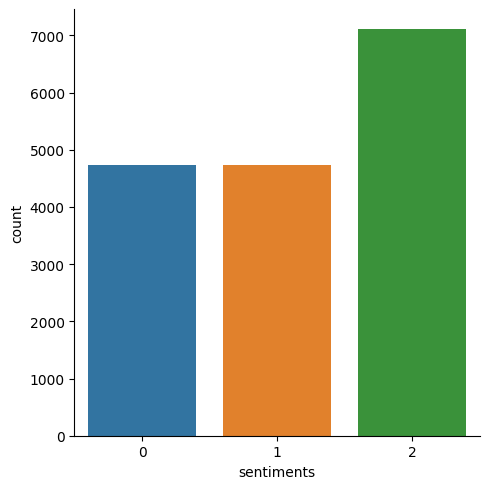

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'].fillna(' '), df['sentiments'].astype('category'), test_size=0.25, random_state=1234)

oversample = il.over_sampling.RandomOverSampler(sampling_strategy = {0: (y_train == 1).sum()})

balanced_df = oversample.fit_resample(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
balanced_X_train = pd.DataFrame(balanced_df[0], columns = ['cleaned_review'])
balanced_y_train = pd.DataFrame(balanced_df[1], columns = ['sentiments'])

X_test = pd.DataFrame(X_test.values.reshape(-1, 1), columns = ['cleaned_review'])
y_test = pd.DataFrame(y_test.values.reshape(-1, 1), columns = ['sentiments'])

print(balanced_X_train.shape)
print(X_test.shape)
sb.catplot(x = "sentiments", kind = 'count', data = balanced_y_train)

In the above graph, sentiments have been categorized so that 0 is negative, 1 is neutral, and 2 is positive. Negative reviews were oversampled to match neutral ones in frequency.

## Convolutional Neural Network

In [5]:
def matrix_to_tensor(X):
    coo = X.tocoo()
    indexes = np.mat([coo.row, coo.col]).transpose()
    tensor = tf.SparseTensor(indexes, coo.data, coo.shape)
    
    return sparse.reorder(tensor)

This function converts a numpy matrix into a tensor and computes a natural reordering so that it can be accepted.

In [6]:
vectorizer = TfidfVectorizer(stop_words = 'english', encoding = 'latin-1')

X_train = vectorizer.fit_transform(balanced_X_train['cleaned_review'].values)
X_test = matrix_to_tensor(vectorizer.transform(X_test['cleaned_review'].values))

print(X_train.shape)
print(X_test.shape)

y_train = np.asarray(balanced_y_train['sentiments'].values).astype('float32')
y_test = np.asarray(y_test['sentiments'].values).astype('float32')

(16586, 8334)
(4335, 8334)


This vectorizer only uses unigrams because the convolutional network cannot handle larger inputs than 8334 without crashing.

In [8]:
# create a validation set

X_val = matrix_to_tensor(X_train[:1000])
partial_X_train = matrix_to_tensor(X_train[1000:])

print(X_val.shape)

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

(1000, 8334)


In [9]:
modelCNN = models.Sequential()
modelCNN.add(layers.Embedding(10, 256, input_length = 8334)) 
modelCNN.add(layers.Conv1D(32, 24, activation = 'relu'))
modelCNN.add(layers.MaxPooling1D(16))
modelCNN.add(layers.Conv1D(16, 12, activation = 'relu'))
modelCNN.add(layers.GlobalMaxPooling1D())
modelCNN.add(layers.Dense(3, activation = 'softmax'))

modelCNN.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [10]:
history = modelCNN.fit(partial_X_train,
                    partial_y_train,
                    epochs = 1,
                    batch_size = 256,
                    validation_data = (X_val, y_val))

61/61 [==============================] - 6841s 112s/step - loss: 1.0846 - sparse_categorical_accuracy: 0.4163 - val_loss: 1.0535 - val_sparse_categorical_accuracy: 0.5510


In [11]:
predCNN = modelCNN.predict(X_test)
predCNN = [[1.0 if p >= 0.5 else 0.0 for p in a] for a in predCNN]
predCNN = [a.index(1.0) if 1.0 in a else 0.0 for a in predCNN]
print(classification_report(y_test, predCNN))

136/136 [==============================] - 322s 2s/step
              precision    recall  f1-score   support

         0.0       0.09      1.00      0.16       375
         1.0       0.00      0.00      0.00      1563
         2.0       0.00      0.00      0.00      2397

    accuracy                           0.09      4335
   macro avg       0.03      0.33      0.05      4335
weighted avg       0.01      0.09      0.01      4335



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model performed horribly, but it has more to do with constraints on training and poor inputs than the architecture itself. Based on the time it took to run just a single epoch, the standard 20 epochs recommended in the notebooks would have taken around 40 hours, and I did not have that sort of time.

## Sequential

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'].fillna(' '), df['sentiments'].astype('category'), test_size=0.25, random_state=1234)

oversample = il.over_sampling.RandomOverSampler(sampling_strategy = {0: (y_train == 1).sum()})

balanced_df = oversample.fit_resample(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
balanced_X_train = pd.DataFrame(balanced_df[0], columns = ['cleaned_review'])
balanced_y_train = pd.DataFrame(balanced_df[1], columns = ['sentiments'])

In [32]:
vectorizer = TfidfVectorizer(stop_words = 'english', encoding = 'latin-1', ngram_range = (1, 2))

X_train = vectorizer.fit_transform(balanced_X_train['cleaned_review'].values)
X_test = matrix_to_tensor(vectorizer.transform(X_test))

print(X_train.shape)
print(X_test.shape)

y_train = np.asarray(balanced_y_train['sentiments'].values).astype('float32')
y_test = np.asarray(y_test).astype('float32')

(16586, 95680)
(4335, 95680)


This vectorizer uses bigrams to get more out of the data for simpler sequential models.

In [33]:
X_val = matrix_to_tensor(X_train[:1000])
partial_X_train = matrix_to_tensor(X_train[1000:])

print(X_val.shape)

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

(1000, 95680)


In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

Dropout layers were added to prevent overfitting, as even with additional dense layers, this model trains extremely quickly.

In [35]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (X_val, y_val))

Epoch 1/20
31/31 [==============================] - 2s 45ms/step - loss: 1.0782 - sparse_categorical_accuracy: 0.4147 - val_loss: 1.0022 - val_sparse_categorical_accuracy: 0.5510
Epoch 2/20
31/31 [==============================] - 1s 39ms/step - loss: 0.9653 - sparse_categorical_accuracy: 0.5589 - val_loss: 0.8375 - val_sparse_categorical_accuracy: 0.6050
Epoch 3/20
31/31 [==============================] - 2s 56ms/step - loss: 0.7816 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.7068 - val_sparse_categorical_accuracy: 0.6150
Epoch 4/20
31/31 [==============================] - 1s 38ms/step - loss: 0.6022 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.5680 - val_sparse_categorical_accuracy: 0.7670
Epoch 5/20
31/31 [==============================] - 1s 36ms/step - loss: 0.4456 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.4501 - val_sparse_categorical_accuracy: 0.8460
Epoch 6/20
31/31 [==============================] - 1s 41ms/step - loss: 0.3136 - sparse_categorical_accu

In [36]:
pred = model.predict(X_test)
pred = [[1.0 if p >= 0.5 else 0.0 for p in a] for a in pred]
pred = [a.index(1.0) if 1.0 in a else 0.0 for a in pred]
print(classification_report(y_test, pred))

136/136 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.60      0.70       375
         1.0       0.81      0.85      0.83      1563
         2.0       0.91      0.92      0.92      2397

    accuracy                           0.87      4335
   macro avg       0.85      0.79      0.82      4335
weighted avg       0.87      0.87      0.87      4335



Surprisingly, the simple sequential network did a fine job with both the validation and test data. Negative reviews were oversampled for training, but the model still struggled with recalling negative reviews, and it performed best with positive reviews because that was the majority class. Training accuracy was significantly higher than testing accuracy, so there was some overfitting.

## Embedding

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'].fillna(' '), df['sentiments'].astype('category'), test_size=0.25, random_state=1234)

oversample = il.over_sampling.RandomOverSampler(sampling_strategy = {0: (y_train == 1).sum()})

balanced_df = oversample.fit_resample(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
balanced_X_train = pd.DataFrame(balanced_df[0], columns = ['cleaned_review'])
balanced_y_train = pd.DataFrame(balanced_df[1], columns = ['sentiments'])

X_test = pd.DataFrame(X_test.values.reshape(-1, 1), columns = ['cleaned_review'])
y_test = pd.DataFrame(y_test.values.reshape(-1, 1), columns = ['sentiments'])

In [44]:
vectorizer = TfidfVectorizer(stop_words = 'english', encoding = 'latin-1')

X_train = vectorizer.fit_transform(balanced_X_train['cleaned_review'].values)
X_test = matrix_to_tensor(vectorizer.transform(X_test))

print(X_train.shape)
print(X_test.shape)

y_train = np.asarray(balanced_y_train['sentiments'].values).astype('float32')
y_test = np.asarray(y_test).astype('float32')

(16586, 8334)
(1, 8334)


In [45]:
X_val = matrix_to_tensor(X_train[:1000])
partial_X_train = matrix_to_tensor(X_train[1000:])

print(X_val.shape)

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

(1000, 8334)


In [52]:
modelE = models.Sequential()
modelE.add(layers.Embedding(1000, 32, input_length = 8334))
modelE.add(layers.Flatten())
modelE.add(layers.Dense(16, activation='relu'))
modelE.add(layers.Dense(8, activation='relu'))
modelE.add(layers.Dense(3, activation='softmax'))

modelE.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [53]:
history = modelE.fit(partial_X_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 256,
                    validation_data = (X_val, y_val))

Epoch 1/20
61/61 [==============================] - 108s 2s/step - loss: 1.1231 - sparse_categorical_accuracy: 0.3977 - val_loss: 1.0833 - val_sparse_categorical_accuracy: 0.5510
Epoch 2/20
61/61 [==============================] - 57s 938ms/step - loss: 1.0886 - sparse_categorical_accuracy: 0.4206 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.5510
Epoch 3/20
61/61 [==============================] - 51s 832ms/step - loss: 1.0841 - sparse_categorical_accuracy: 0.4206 - val_loss: 1.0532 - val_sparse_categorical_accuracy: 0.5510
Epoch 4/20
61/61 [==============================] - 52s 859ms/step - loss: 1.0823 - sparse_categorical_accuracy: 0.4206 - val_loss: 1.0467 - val_sparse_categorical_accuracy: 0.5510
Epoch 5/20
61/61 [==============================] - 50s 821ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.4206 - val_loss: 1.0447 - val_sparse_categorical_accuracy: 0.5510
Epoch 6/20
61/61 [==============================] - 63s 1s/step - loss: 1.0819 - sparse_categoric

In [ ]:
predE = modelE.predict(X_test)
predE = [[1.0 if p >= 0.5 else 0.0 for p in a] for a in predE]
predE = [a.index(1.0) if 1.0 in a else 0.0 for a in predE]
print(classification_report(y_test, predE))

Just like with the convolutional nenural network, my oversampled sparse tensors did not play nice with the model. Even when all of the input shapes matched up, this simple model with embedding did not extract much meaning from the text, and both training and validation accuracy flatlined with each epoch. Given more time, embedding or one-hot encoding may have improved the simple model, but I was unable to acheive better results. It also probably hurts that this model moved back to unigrams rather than bigrams.